<a href="https://colab.research.google.com/github/serzaraisk/Statistics/blob/main/Statistics_cheat_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
import scipy as sc
import requests
import base64
from statsmodels.stats.weightstats import DescrStatsW 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [19]:
def get_txt_from_github(url):
  req = requests.get(url)
  return req.text.decode()

# Contents


*   List item

*   List item
*   List item


*   List item



## T confindence Intervals

For a sample of 915 biochemistry graduate students we now hom many papers they produced during the last 3 years of their PhD prodram. 

How do we estimate the average number of papers with uncertainty?

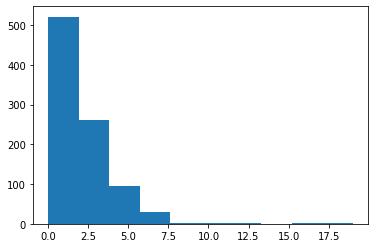

In [21]:
from numpy import loadtxt
bio_papers = loadtxt('https://raw.githubusercontent.com/serzaraisk/Statistics/main/bioChemists.txt')
plt.hist(bio_papers);

### Estimating the mean
Simple point estimate of the mean:

In [22]:
bio_papers.mean()

1.692896174863388

Asymptotic confidence interval:

In [ ]:
from statsmodels.stats.weightstats import DescrStatsW 
print("95% confidence interval:", DescrStatsW(bio_papers).tconfint_mean())

95% confidence interval: (1.5679321925466905, 1.8178601571800854)


Another way to calculate it:

In [ ]:
from statsmodels.stats.weightstats import _tconfint_generic
n = len(bio_papers)
print("95% confidence interval:", _tconfint_generic(bio_papers.mean(), 
                                                    bio_papers.std(ddof=1) / np.sqrt(n),
                                                    dof = n-1,
                                                    alpha=0.05,
                                                    alternative = 'two-sided'))

95% confidence interval: (1.5679321925466905, 1.8178601571800854)


Yet another way, without any external libraries:

In [ ]:
mean = bio_papers.mean()
std = bio_papers.std(ddof=1)
n = len(bio_papers)
alpha = 0.05
CI = (mean - sc.stats.t.ppf(1 - alpha / 2.0, n-1) * std / np.sqrt(n),
      mean + sc.stats.t.ppf(1 - alpha / 2.0, n-1) * std / np.sqrt(n))
        
print("95% confidence interval:", CI)

95% confidence interval: (1.5679321925466905, 1.8178601571800854)


## BootStrap methods

Verizon was an Incumbent Local Exchange Carrier (ILEC), responsible for maintaining land-line phone service in certain areas. Verizon also sold long-distance service, as did a number of competitors, termed Competitive Local Exchange Carriers (CLEC). When something went wrong, Verizon was responsible for repairs, and was supposed to make repairs as quickly for CLEC long-distance customers as for their own. The New York Public Utilities Commission (PUC) monitored fairness by comparing repair times for Verizon and different CLECs, for different classes of repairs and time periods.

The data is for one combination of CLEC, class of service, and period.

In [26]:
verizon_data = pd.read_csv('https://raw.githubusercontent.com/serzaraisk/Statistics/main/verizon.txt', sep='\t')
verizon_data.head()

,Time,Group
0,17.50,ILEC
1,2.40,ILEC
2,0.00,ILEC
3,0.65,ILEC
4,22.23,ILEC


In [27]:
ilec_time = verizon_data[verizon_data.Group == 'ILEC'].Time.values
clec_time = verizon_data[verizon_data.Group == 'CLEC'].Time.values

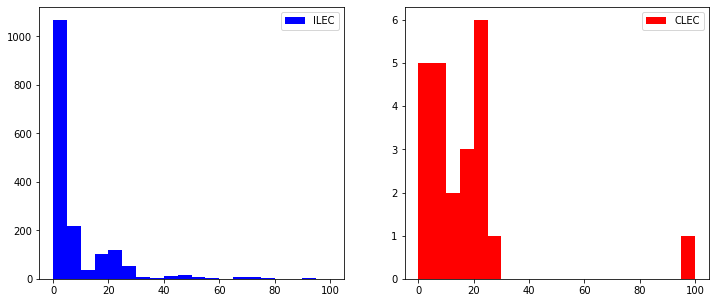

In [28]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(ilec_time, bins = 20, color = 'b', range = (0, 100), label = 'ILEC')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(clec_time, bins = 20, color = 'r', range = (0, 100), label = 'CLEC')
pylab.legend();

### Percentile bootstrap

Standard Python libraries do not have implementation of bootstrap methods. The basic one – percentile bootstrap – is easy to implement ourselves. 

In [29]:
def get_bootstrap_samples(x, n_resamples):
    indices = np.random.randint(0, len(x), (n_resamples, len(x)))
    resamples = x[indices]
    return resamples

In [30]:
def percentile_interval(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

### For a parameter of a single sample

In [31]:
np.random.seed(0)

ilec_median_scores = list(map(np.median, get_bootstrap_samples(ilec_time, 5000)))
clec_median_scores = list(map(np.median, get_bootstrap_samples(clec_time, 5000)))

print("95% confidence interval for the ILEC median repair time:",  percentile_interval(ilec_median_scores, 0.05))
print("95% confidence interval for the CLEC median repair time:",  percentile_interval(clec_median_scores, 0.05))

95% confidence interval for the ILEC median repair time: [3.22  3.825]
95% confidence interval for the CLEC median repair time: [ 5.8  20.28]


### For a combination of parameters of two samples

In [32]:
print("Estimated difference between repait times:", np.median(clec_time) - np.median(ilec_time))

Estimated difference between repait times: 10.74


In [33]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(ilec_median_scores, clec_median_scores)))
print("95% confidence interval for the difference between median repair times:",  
      percentile_interval(delta_median_scores, 0.05))

95% confidence interval for the difference between median repair times: [ 2.08  16.655]


### BCa bootstrap
An external library https://pypi.org/project/bootstrap-stat/ actually has more exciting bootstrap methods implemented, including BCa bootstrap! The library is rather new and fresh, but seems to be working fine! Here are the examples, you'd have to install the library if you want to run them. 

In [35]:
! pip install bootstrap_stat
from bootstrap_stat import bootstrap_stat as bp

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 71kB 6.9MB/s 


### For a parameter of a single sample

In [36]:
dist_ilec = bp.EmpiricalDistribution(ilec_time)
dist_clec = bp.EmpiricalDistribution(clec_time)

In [37]:
print("95% confidence interval for the ILEC median repair time:", 
      bp.bcanon_interval(dist_ilec, np.median, ilec_time, B=5000))
print("95% confidence interval for the CLEC median repair time:", 
      bp.bcanon_interval(dist_clec, np.median, clec_time, B=5000))

95% confidence interval for the ILEC median repair time: (3.26, 3.78)
95% confidence interval for the CLEC median repair time: (5.45, 19.88)


### For a combination of parameters of two samples

In [38]:
joint_dist = bp.MultiSampleEmpiricalDistribution((ilec_time, clec_time))

def median_diff(two_sample_tuple):
    return np.median(two_sample_tuple[1]) - np.median(two_sample_tuple[0])

print("95% confidence interval for the difference between median repair times:", 
      bp.bcanon_interval(joint_dist, median_diff, (ilec_time, clec_time), B=5000))

95% confidence interval for the difference between median repair times: (2.13, 16.4)
